In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from yahoofinancials import YahooFinancials

In [2]:
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

#save_sp500_tickers()

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));

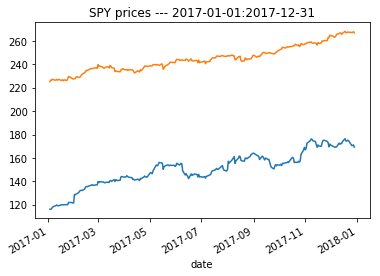

In [4]:
tickers=['AAPL', 'SPY']

for ticker in tickers:
    download_csv_data(ticker=ticker, 
                      start_date='2017-01-01', 
                      end_date='2017-12-31', 
                      freq='daily', 
                      path='european/daily/'+ticker.strip(' .^')+'.csv')
    df=None

In [5]:
from zipline.data import bundles
from zipline.data.bundles.csvdir import csvdir_equities
import os

start_session = pd.Timestamp('2017-01-03', tz='utc')
end_session = pd.Timestamp('2017-12-29', tz='utc')

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(),'european')
# Create an ingest function 
ingest_func = csvdir_equities(['daily'], os.environ['ZIPLINE_ROOT'])

# Register the data bundle and its ingest function
bundles.register('eu_stocks', ingest_func, 
                 calendar_name='NYSE',  # Euronext Amsterdam
                start_session=start_session,
                end_session=end_session);

In [6]:
bundles.ingest('eu_stocks')


 | AAPL: sid 0
 | SPY: sid 1


In [7]:
bundle_data = bundles.load('eu_stocks')

### Algorithm

In [29]:
#: NOTICE HOW THIS IS OUTSIDE INITIALIZE, BECAUSE IT IS, WE CAN REDEFINE IT EVERYTIME WE REDINE INITIALIZE


from zipline.api import *
short_mavg_days = 20
long_mavg_days = 50

def initialize(context):
    context.aapl = symbol('AAPL')
    context.spy = symbol('SPY')
    
    # Set context parameters based on global parameters 
    context.short_mavg_days = short_mavg_days
    context.long_mavg_days = long_mavg_days
    
    # Register 2 histories that track daily prices,
    # one with a short window and one with a long window

    # Used to warm-up moving averages
    context.i = 0
    
def handle_data(context, data):
    
    # Skip days to get full windows
    context.i += 1
    if context.i < context.long_mavg_days:
        return
    
    # Compute averages
    # history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.aapl, 'price', bar_count=5, frequency="1d").mean()
    long_mavg = data.history(context.aapl, 'price', bar_count=10, frequency="1d").mean()

    #sym = symbol('AAPL')

    # Trading logic
    if short_mavg[context.aapl] > long_mavg[context.aapl]:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        print(1)
        #order_target_percent(context.aapl, 1)
    elif short_mavg[context.aapl] < long_mavg[context.aapl]:
        order_target_percent(context.aapl, 0)


To now test this algorithm on financial data, zipline provides three interfaces: A command-line interface, IPython Notebook magic, and run_algorithm().

### Ipython notebook magic method to execute

In [9]:
%load_ext zipline

In [30]:
%zipline --start 2017-1-4 --end 2017-12-28 --capital-base 250 --bundle eu_stocks -o buy_and_hold.pkl --trading-calendar NYSE


/Users/cnakhare/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/Users/cnakhare/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


TypeError: 'float' object is not subscriptable

### run_algorithm() method to execute

If using some other stock like eg. European here, make sure to use proper trading_calendar or it would through error.

In [ ]:
from datetime import datetime
from trading_calendars import get_calendar
import pytz
perf = zipline.run_algorithm(start=datetime(2017, 1, 2, 0 , 0, 0, 0, pytz.utc),
                      end=datetime(2017, 12, 29,0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      bundle='eu_stocks',
                      trading_calendar=get_calendar('XAMS'))
perf